# Parameter Estimation Workflow for conversion reaction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import norm
from scipy.integrate import solve_ivp, dblquad
import random

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.models import GenerativeModel

In [2]:
%load_ext autoreload
%autoreload 2

## Simulator settings

In [3]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range for log-parameters: k_1, k_2 ~ N(-0.75, 0.25²) iid.
    p_samples = np.random.normal(-0.75, 0.25, size=(batch_size, 2))
    return p_samples.astype(np.float32)


# ODE model for conversion reaction    
def conversion_reaction(t, x, theta):
    theta = 10**theta
    return np.array([-theta[0]*x[0]+theta[1]*x[1], theta[0]*x[0]-theta[1]*x[1]])

x0 = [1,0]   # initial condition       
sigma = 0.015   # noise standard deviation
n_obs = 3
time_points = np.linspace(0, 10, n_obs)
missing_max = 2


def batch_simulator_augment01(prior_samples, n_obs):
    """
    Simulate multiple conversion model datasets with missing values and augmentation by zeros/ones
    """   
    n_sim = prior_samples.shape[0]   # batch size 
    sim_data = np.ones((n_sim, n_obs, 2), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_obs observations
    n_missing = np.random.randint(0, missing_max+1, size=n_sim)
    
    for m in range(n_sim):
        theta = 10**prior_samples[m]
        s = theta[0] + theta[1]
        b = theta[0]/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        sol = state_2(time_points)
        sim_data[m, :, 0] = sol + np.random.normal(0, sigma, size = n_obs)   # observable: y = x_2 + N(0,sigma²) 
        
        # artificially induce missing data
        missing_indices = random.sample(range(n_obs), n_missing[m])
        sim_data[m][missing_indices] = np.array([-1.0, 0.0])  
        
    return sim_data   


def batch_simulator_insert(prior_samples, n_obs):
    """
    Simulate multiple conversion model datasets with missing values and insert -1
    """   
    n_sim = prior_samples.shape[0]   # batch size 
    sim_data = np.ones((n_sim, n_obs, 1), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_obs observations
    n_missing = np.random.randint(0, missing_max+1, size=n_sim)
    
    for m in range(n_sim):
        theta = 10**prior_samples[m]
        s = theta[0] + theta[1]
        b = theta[0]/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        sol = state_2(time_points)
        sim_data[m, :, 0] = sol + np.random.normal(0, sigma, size = n_obs)   # observable: y = x_2 + N(0,sigma²) 
        
        # artificially induce missing data
        missing_indices = random.sample(range(n_obs), n_missing[m])
        sim_data[m][missing_indices] = np.array([-1.0])   
        
    return sim_data 


def batch_simulator_timepoints(prior_samples, n_obs):
    """
    Simulate multiple conversion model datasets with missing values and time labels (present time points)
    """   
    n_sim = prior_samples.shape[0]   # batch size 
    n_missing = np.random.randint(0, missing_max+1)
    n_present = n_obs - n_missing
    sim_data = np.empty((n_sim, n_present, 2), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_present observations
    
    for m in range(n_sim):
        theta = 10**prior_samples[m]
        s = theta[0] + theta[1]
        b = theta[0]/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        
        # artificially induce missing data 
        missing_indices = random.sample(range(n_obs), n_missing)
        present_indices = np.setdiff1d(range(n_obs), missing_indices)
        present_timepoints = time_points[present_indices]
        sol = state_2(present_timepoints)
        sim_data[m, :, 0] = sol + np.random.normal(0, sigma, size = n_present)   # observable: y = x_2 + N(0,sigma²)
        sim_data[m, :, 1] = present_timepoints   # time labels
        
    return sim_data 

We build an amortized parameter estimation network.

In [4]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

## Computational faithfulness

In [5]:
# Demo dataset 1 (n_missing = 1)
param_prior = np.array([[-0.9764454, -0.6597913]])
result = [np.array([-0.01174284,  0.27580237,  0.3169578 ]), np.array([0, 1]), np.array([0., 5.])]

In [5]:
# Demo dataset 2 (n_missing = 1)
param_prior = np.array([[-0.7747589, -0.7236521]])
result = [np.array([-3.23788010e-04,  4.09819164e-01,  4.91645435e-01]), np.array([0, 2]), np.array([ 0., 10.])]

In [12]:
# Demo dataset 3 (n_missing = 2)
param_prior = np.array([[-0.71007127, -0.53789186]])
result = [np.array([0.00947389, 0.35028624, 0.39525798]), np.array([0]), np.array([0.])]

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_augment01_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300


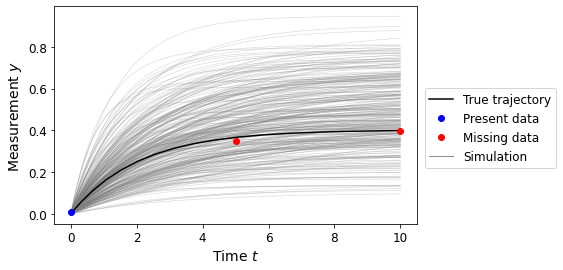

In [13]:
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_augment01_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True)
sim_data = np.ones((1, n_obs, 2), dtype=np.float32)
sim_data[0, :, 0] = result[0]
missing_indices = np.setdiff1d(range(n_obs), result[1])
sim_data[0][missing_indices] = np.array([-1.0, 0.0])
x_data = sim_data
n_post_samples = 350
param_samples = amortizer.sample(x_data, n_post_samples) 

# Posterior predictive check
fig = plt.figure(figsize=(6.5, 4))
plt.rcParams['font.size'] = 12

for k in range(301):
    rhs = lambda t,x: conversion_reaction(t, x, param_samples[k])
    sol = solve_ivp(rhs, t_span = (0,10), y0 = x0, atol = 1e-9, rtol = 1e-6)
    if k == 0:
        plt.plot(sol.t[0], sol.y[1][0], color='grey', label='Simulation', linewidth=0.9)
    else: 
        plt.plot(sol.t, sol.y[1], color='grey', linewidth=0.6, alpha=0.3)

rhs = lambda t,x: conversion_reaction(t, x, param_prior[0])
sol = solve_ivp(rhs, t_span = (0,10), y0 = x0, atol = 1e-9, rtol = 1e-6)
plt.plot(sol.t, sol.y[1], color='black', label='True trajectory') 
present_indices = result[1]
missing_indices = np.setdiff1d(range(n_obs), present_indices)
plt.plot(time_points[present_indices], result[0][present_indices], 'o', color='blue', label='Present data')
plt.plot(time_points[missing_indices], result[0][missing_indices], 'o', color='red', label='Missing data')

plt.xlabel('Time $t$', fontsize=14)
plt.ylabel('Measurement $y$', fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,3,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12, bbox_to_anchor=(1.4,0.65))
plt.show()
fig.savefig("figures/{}_Re-simulation.png".format('CR3_missing_3'), dpi=600, bbox_inches='tight')

In [6]:
def prior_eval(x,y):   
    # Evaluates prior probability p(theta) according to k_1, k_2 ~ N(-0.75, 0.25²) iid.
    return norm.pdf(x,-0.75,0.25) * norm.pdf(y,-0.75,0.25)

def likelihood(x,y):   
    # Calculates likelihood p(x_{1:N} | theta) by ignoring the missing data
    x = 10**x
    y = 10**y
    s = x + y
    b = x/s
    state_2 = lambda t: b - b * np.exp(-s*t)
    sol = state_2(result[2])
    residual = (result[0][result[1]] - sol)/sigma
    nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
    return np.exp(-nllh)

def unnormalized_posterior(x,y):   
    # Evaluates the unnormalized posterior probability p(theta | x_{1:N}) according to Bayes' formula
    return likelihood(x,y) * prior_eval(x,y)

# scaling factor
scaling_factor = dblquad(unnormalized_posterior, -2.25, 0.75, lambda y: -2.25, lambda y: 0.75)
print(scaling_factor)
# normalized posterior
posterior_xy = lambda x,y: unnormalized_posterior(x,y)/scaling_factor[0]

(53.37333535088461, 1.3357098687157704e-06)


TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_augment01_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300
TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_insert-1_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300
TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_timepoints_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300


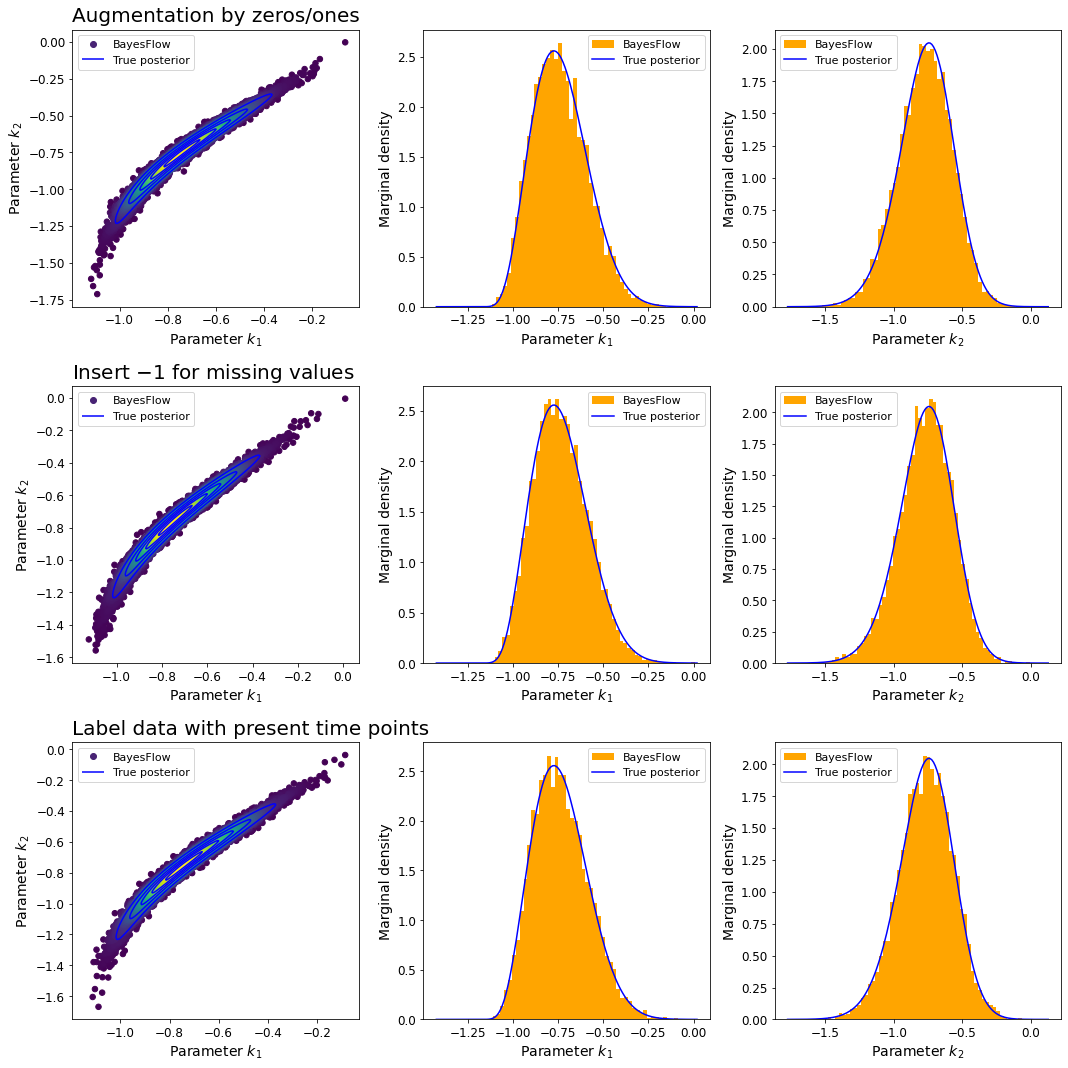

In [48]:
fig = plt.figure(figsize=(15, 15))
plt.rcParams['font.size'] = 12
n_post_samples = 7500


# Method 1: augment01
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_augment01_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True) 
sim_data = np.ones((1, n_obs, 2), dtype=np.float32)
sim_data[0, :, 0] = result[0]
missing_indices = np.setdiff1d(range(n_obs), result[1])
sim_data[0][missing_indices] = np.array([-1.0, 0.0])
x_data = sim_data
param_samples_1 = amortizer.sample(x_data, n_post_samples)
mean_sample = np.mean(param_samples_1, axis=0)
cov_sample = np.cov(param_samples_1.transpose())
mean_x = mean_sample[0]
mean_y = mean_sample[1]
std_x = np.sqrt(cov_sample[0, 0])
std_y = np.sqrt(cov_sample[1, 1])

# Level sets of analytic posterior distribution
grid = 201
A = np.linspace(mean_x - 3 * std_x, mean_x + 3 * std_x, grid)
B = np.linspace(mean_y - 3 * std_y, mean_y + 3 * std_y, grid)
true_posterior = np.zeros((grid, grid))
for iy in range(0, grid):
    for ix in range(0, grid):
        true_posterior[iy][ix] = posterior_xy(A[ix], B[iy])
        
# Check marginal densities
grid = 151
C = np.linspace(mean_x - 4.5 * std_x, mean_x + 5 * std_x, grid) ### 5
D = np.linspace(mean_y - 5 * std_y, mean_y + 4.5 * std_y, grid) ###5
bounds = np.array([mean_x - 8 * std_x, mean_x + 8 * std_x, mean_y - 8 * std_y, mean_y + 8 * std_y])
marginal_x = np.zeros(grid)
for i in range(grid):
    x = C[i]
    integrand_y = lambda y: posterior_xy(x, y)
    marginal_x[i] = quad(integrand_y, bounds[2], bounds[3])[0]
marginal_y = np.zeros(grid)
for j in range(grid):
    y = D[j]
    integrand_x = lambda x: posterior_xy(x, y)
    marginal_y[j] = quad(integrand_x, bounds[0], bounds[1])[0]

plot_posterior_comparison(param_samples_1, A, B, C, D, true_posterior, marginal_x, marginal_y, 1, 'Augmentation by zeros/ones')


# Method 2: insert-1
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_insert-1_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True) 
sim_data = np.ones((1, n_obs, 1), dtype=np.float32)
sim_data[0, :, 0] = result[0]
missing_indices = np.setdiff1d(range(n_obs), result[1])
sim_data[0][missing_indices] = np.array([-1.0])
x_data = sim_data
param_samples_2 = amortizer.sample(x_data, n_post_samples)
plot_posterior_comparison(param_samples_2, A, B, C, D, true_posterior, marginal_x, marginal_y, 2, 'Insert $-1$ for missing values')


# Method 3: timepoints
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_timepoints_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True) 
n_present = len(result[1])
sim_data = np.ones((1, n_present, 2), dtype=np.float32)
sim_data[0, :, 0] = result[0][result[1]]
sim_data[0, :, 1] = result[2]
x_data = sim_data
param_samples_3 = amortizer.sample(x_data, n_post_samples)
plot_posterior_comparison(param_samples_3, A, B, C, D, true_posterior, marginal_x, marginal_y, 3, 'Label data with present time points')


plt.tight_layout()
plt.show()
fig.savefig("figures/{}_posterior_comparison.png".format('CR3_missing_2'), dpi=300, bbox_inches='tight')   

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_augment01_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300
TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_insert-1_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300
TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_timepoints_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300


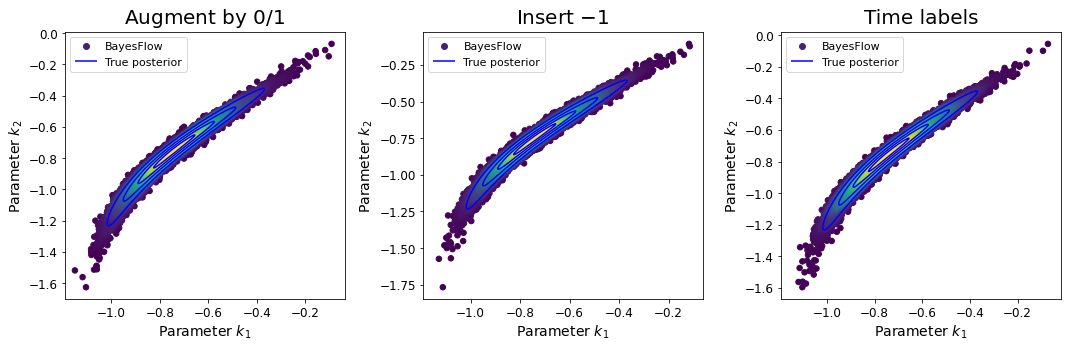

In [10]:
fig = plt.figure(figsize=(15, 5))
plt.rcParams['font.size'] = 12
n_post_samples = 7500


# Method 1: augment01
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_augment01_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True) 
sim_data = np.ones((1, n_obs, 2), dtype=np.float32)
sim_data[0, :, 0] = result[0]
missing_indices = np.setdiff1d(range(n_obs), result[1])
sim_data[0][missing_indices] = np.array([-1.0, 0.0])
x_data = sim_data
param_samples_1 = amortizer.sample(x_data, n_post_samples)
mean_sample = np.mean(param_samples_1, axis=0)
cov_sample = np.cov(param_samples_1.transpose())
mean_x = mean_sample[0]
mean_y = mean_sample[1]
std_x = np.sqrt(cov_sample[0, 0])
std_y = np.sqrt(cov_sample[1, 1])

# Level sets of analytic posterior distribution
grid = 201
A = np.linspace(mean_x - 3 * std_x, mean_x + 3 * std_x, grid)
B = np.linspace(mean_y - 3 * std_y, mean_y + 3 * std_y, grid)
true_posterior = np.zeros((grid, grid))
for iy in range(0, grid):
    for ix in range(0, grid):
        true_posterior[iy][ix] = posterior_xy(A[ix], B[iy])

plot_2D_comparison(param_samples_1, A, B, true_posterior, 1, 'Augment by $0/1$')


# Method 2: insert-1
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_insert-1_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True) 
sim_data = np.ones((1, n_obs, 1), dtype=np.float32)
sim_data[0, :, 0] = result[0]
missing_indices = np.setdiff1d(range(n_obs), result[1])
sim_data[0][missing_indices] = np.array([-1.0])
x_data = sim_data
param_samples_2 = amortizer.sample(x_data, n_post_samples)
plot_2D_comparison(param_samples_2, A, B, true_posterior, 2, 'Insert $-1$')


# Method 3: timepoints
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_timepoints_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True) 
n_present = len(result[1])
sim_data = np.ones((1, n_present, 2), dtype=np.float32)
sim_data[0, :, 0] = result[0][result[1]]
sim_data[0, :, 1] = result[2]
x_data = sim_data
param_samples_3 = amortizer.sample(x_data, n_post_samples)
plot_2D_comparison(param_samples_3, A, B, true_posterior, 3, 'Time labels')


plt.tight_layout()
plt.show()
fig.savefig("figures/{}_2D_comparison.png".format('CR3_missing_2'), dpi=300, bbox_inches='tight')   

augment01, insert-1, timepoints

KL loss: -4.346, -4.345, -4.332